#Zadanie 2 (7 pkt)
Celem zadania jest rozwiązanie zadania optymalizacji przy pomocy algorytmu genetycznego. Należy znaleźć minimum zadanej funkcji:
\begin{equation}
f(x) = 1.5-\exp \left\{-x_1^2-x_2^2\right\}-0.5 \exp \left\{-\left(x_1-1\right)^2-\left(x_2+2\right)^2\right\}
\end{equation}
Należy wykorzystać mechanizmy krzyżowania punktowego, mutacji oraz selekcji turniejowej. Proszę wykorzystać przygotowany szkielet i zaimplementować niezbędne metody. Opracowane oprogramowanie powinno być uniwersalne - wymiar funkcji, której minimum szukamy może być dowolny (mechanizm *args). Punktacja wygląda następująco:

*   Stworzenie obiektu klasy *Chromosome* z polem *array*, które jest wektorem aktywnych i nieaktywnych genów - **0.5 pkt**
*   Implementacja metody *decode*, która dekoduje część chromosomu (określoną przez początek (*lower_bound*) i koniec (*upper_bound*)) do postaci liczby rzeczywistej. *aoi* to zakres wartości zdekodowanej liczby rzeczywistej. Przykład: liczba 135 w postaci binarnej zapisana przy użyciu 8 bitów to 1000 0111, jeśli nasze *aoi* to [0, 1], to 135 sprowadzone do tego zakresu to 0.529. Można skorzystać z funkcji pomocniczej *min_max_norm* - **1 pkt**
*   Implementacja metody *mutation*, która przyjmuje jako argument prawdopodobieństo mutacji i zmienia wartość jedego, losowego genu na przeciwną - **0.5 pkt**
*   Implementacja metody *crossover*, która wykonuje operację krzyżowania jednopunktowego - **1 pkt**
*   Implementacja metody *eval_objective_func*, która dekoduje cały chromosom (otrzymuje się argumenty funkcji) oraz zwraca wartość funkcji celu dla tych argumentów - **1 pkt**
*   Implementacja metody *tournament_selection*, która przeprowadza selekcję turniejową - **1 pkt**
*   Implementacja metody *reproduce*, która generuje nowe pokolenie - z pewnym prawdopodobieństwem przeprowadza krzyżowanie jednopunktowe lub "przerzuca" rodziców do nowego pokolenia - **0.5 pkt**
*   Implementacja metody *run*, która wykonuje cały alorytm genetyczny dla określonej liczby pokoleń. W każdym pokoleniu należy zapisać dane osobnika z najlepszym chromosomem zdekodowane wartości x i y oraz wartość funkcji strat dla tego osobnika - **0.5 pkt**
*   Proszę, podobnie jak miało to miejsce w przypadku metody gradientowej z poprzednich zajęć, wygenerować wykres przy użyciu funkcji *plot_func* (w przypadku innego typu argumentu *trace*, funkcję można zmodyfikować. Wykres powinien przedstawiać funkcję, której minimum poszukujemy oraz punkty odpowiadające najlepszym osobnikom w danych generacjach, których kolor jest coraz jaśniejszy wraz ze zbliżaniem się do minimum. Proszę zapisać swoje wnioski, w szczególności w odniesieniu do metody gradientowej. - **1 pkt**


In [6]:
import numpy as np
import matplotlib.pyplot as plt

In [7]:
def min_max_norm(val, min_val, max_val, new_min, new_max):
  return (val - min_val) * (new_max - new_min) / (max_val - min_val) + new_min

In [8]:
class Chromosome:
  def __init__(self, length, array=None): #if array is None it should be initialized with random binary vector
    self.length = length
    if array is not None:
      self.array = np.copy(array)
    else:
      self.array = np.random.choice([0, 1], size=self.length)

  def decode(self, lower_bound, upper_bound, aoi):
    nr = 0
    ran = upper_bound-lower_bound
    for i in range(ran):
      nr += self.array[upper_bound - 1 - i]*(2**i)
    new_nr = min_max_norm(nr, 0, 2**ran-1, aoi[0], aoi[1]) 
    return new_nr

  def mutation(self, probability):
    if np.random.rand() < probability:
      i = np.random.randint(self.length-1)
      self.array[i] = 1 - self.array[i]

  def crossover(self, other):
    point = np.random.randint(self.length-1)
    new_array1 = np.array([], dtype=int)
    new_array2 = np.array([], dtype=int)
    for i in range(point+1):
      new_array1 = np.append(new_array1, self.array[i])
      new_array2 = np.append(new_array2, other.array[i])
    for i in range(point+1, self.length):
      new_array1 = np.append(new_array1, other.array[i])
      new_array2 = np.append(new_array2, self.array[i])
    return Chromosome(self.length, new_array1), Chromosome(self.length, new_array2)

In [9]:
class GeneticAlgorithm:
  def __init__(self, chromosome_length, obj_func_num_args, objective_function, aoi, population_size=500,
               tournament_size=2, mutation_probability=0.05, crossover_probability=0.8, num_steps=30):
    assert chromosome_length % obj_func_num_args == 0, "Number of bits for each argument should be equal"
    self.chromosome_length = chromosome_length
    self.obj_func_num_args = obj_func_num_args
    self.bits_per_arg = int(chromosome_length / obj_func_num_args)
    self.objective_function = objective_function
    self.aoi = aoi
    self.population_size = population_size
    self.tournament_size = tournament_size
    self.mutation_probability = mutation_probability
    self.crossover_probability = crossover_probability
    self.num_steps = num_steps
    self.pop = np.empty(population_size, dtype=Chromosome)

  def eval_objective_func(self, chromosome):
    point = self.bits_per_arg
    lower = 0
    upper = point
    arg = np.empty(self.obj_func_num_args)
    for i in range(self.obj_func_num_args):
      arg[i] = chromosome.decode(lower, upper, self.aoi)
      lower += point
      upper += point
    func_point = [self.objective_function(*arg), arg]
    return func_point

  def tournament_selection(self):
    temp_chrom = np.empty(self.tournament_size, dtype=Chromosome)
    temp_func = np.empty(self.tournament_size, dtype=float)
    temp = 0
    new_pop = np.empty(self.population_size, dtype=Chromosome)
    for i in range(self.population_size):
      for j in range(self.tournament_size):
        temp = np.random.choice(self.pop)
        temp_chrom[j] = temp
        temp_func[j] = self.eval_objective_func(temp)[0]
      temp_tour = zip(temp_chrom, temp_func)
      best = min(temp_tour, key=lambda x: x[1])
      new_pop[i] = best[0]
    return new_pop

  def reproduce(self, parents):
    new_pop = np.empty(self.population_size, dtype=Chromosome)
    for i in range(0, self.population_size - 1, 2):
      parent1, parent2 = np.random.choice(parents, size=2, replace=False)
      if np.random.rand() < self.crossover_probability:
        child1, child2 = parent1.crossover(parent2)
        child1.mutation(self.mutation_probability)
        child2.mutation(self.mutation_probability)
        new_pop[i] = child1
        new_pop[i+1] = child2
      else:
        new_pop[i] = parent1
        new_pop[i+1] = parent2
      if self.population_size%2 != 0:
        new_pop[-1] = np.random.choice(parents)
    return new_pop

  def plot_func(self, trace):
    X = np.arange(-2, 3, 0.05)
    Y = np.arange(-4, 2, 0.05)
    X, Y = np.meshgrid(X, Y)
    Z = self.objective_function(X, Y)
    plt.figure()
    plt.contour(X, Y, Z, 10)
    cmaps = [[ii / len(trace), 0, 0] for ii in range(len(trace))]
    plt.scatter([x[0] for x in trace], [x[1] for x in trace], c=cmaps)
    plt.show()

  def run(self):
    trace = np.empty((0, self.obj_func_num_args))
    temp = np.empty(self.population_size, dtype=object)

    for i in range(self.population_size):
      self.pop[i] = Chromosome(self.chromosome_length)

    for i in range(self.num_steps):
      self.pop = np.copy(self.reproduce(self.tournament_selection()))
      for j in range(self.population_size):
        func_value, args = self.eval_objective_func(self.pop[j])
        temp[j] = (func_value, args, self.pop[j].array)
      best = min(temp, key=lambda x: x[0])
      avg_args = np.mean([x[1] for x in temp], axis=0)
      trace = np.vstack((trace, avg_args))
    self.plot_func(trace)
    print(f"Best chromosome: {best[2]}")
    print(f"Best function: {best[0]} for coordinates: {best[1]}")

Chromosome length: 24
Total population: 500
Tournament size: 2
Mutation probability: 0.05
Crossover probability: 0.8


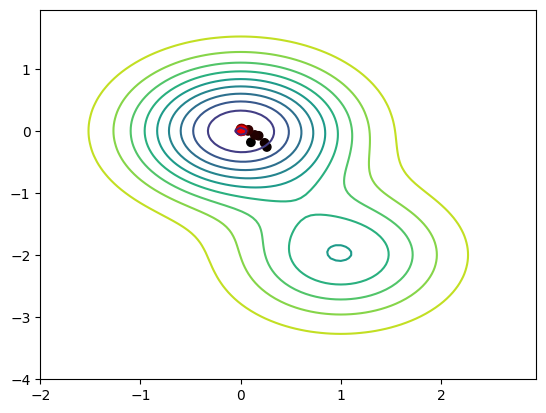

Best chromosome: [1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0]
Best function: 0.4966301866522001 for coordinates: [0.003663  0.0007326]


In [10]:
def func(*args):
    X, Y = args
    return 1.5 - np.exp(-X ** (2) - Y ** (2)) - 0.5 * np.exp(-(X - 1) ** (2) - (Y + 2) ** (2))

algo = GeneticAlgorithm(24, 2, func, [-3, 3])
print(f"Chromosome length: {algo.chromosome_length}")
print(f"Total population: {algo.population_size}")
print(f"Tournament size: {algo.tournament_size}")
print(f"Mutation probability: {algo.mutation_probability}")
print(f"Crossover probability: {algo.crossover_probability}")
algo.run()

Wykresy funkcji pokazują średnią wszystkich punktów każdej generacji zamiast jednego najlepszego punktu aby lepiej odzwierciedlić zmiany w całym pokoleniu.
Jak wynika z poniższych zdjęć, możemy wyciągnąć kilka wniosków na temat metody algorytmu genetycznego:

- Za mały chromosom zaniża potencjalną różnorodność populacji, przez co ryzykujemy utknięcie w suboptymalnym minimum lokalnym
- Podobnie jest z populacją. Jeśli jest ona za mała, brakuje różnorodności genetycznej by móc efektywnie znaleźć minimum
- Im większy rozmiar turnieju, tym szybciej odnajdziemy nasze minimum.
- Zbyt wielka szansa na mutację robi populację niestabilną, przez co nie może ona czasami znaleźć minimum
- Nawet przy małej szansie na krzyżowanie, jeśli populacja jest odpowiednio wielka, minimum powinno zostać odnalezione

W porównaniu do metody gradientowej, algorytm genetyczny jest o wiele bardziej chaotyczny oraz wymaga więcej odpowiednio dobranych zmiennych by zwrócić dobry wynik. Na dodatek, wymaga więcej iteracji by odnaleźć swój cel. Ale w przeciwieństwie do metody gradientowej, ma on mniejsze szansę na utknięcie w lokalnym minimum, co powoduje że jest lepsze do szukania minimów globalnych.

Długość chromosomu = 8, populacja = 10, rozmiar turnieju = 2, szansa na mutację = 0.05, szansa na krzyżowanie = 0.8
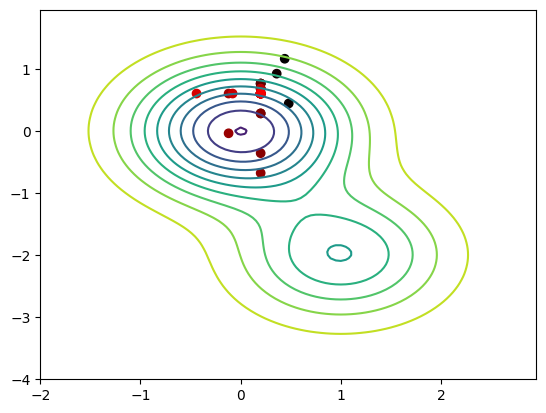

Długość chromosomu = 8, populacja = 500, rozmiar turnieju = 2, szansa na mutację = 0.05, szansa na krzyżowanie = 0.8
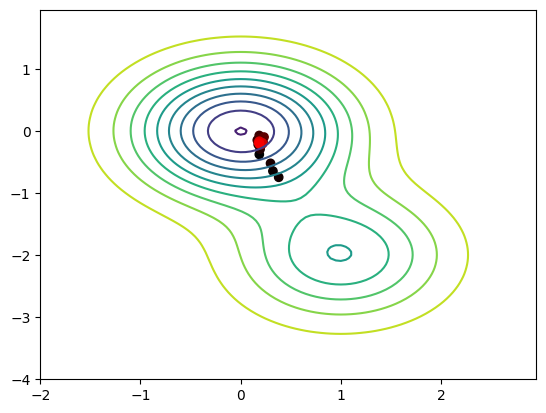

Długość chromosomu = 10, populacja = 500, rozmiar turnieju = 2, szansa na mutację = 0.05, szansa na krzyżowanie = 0.8
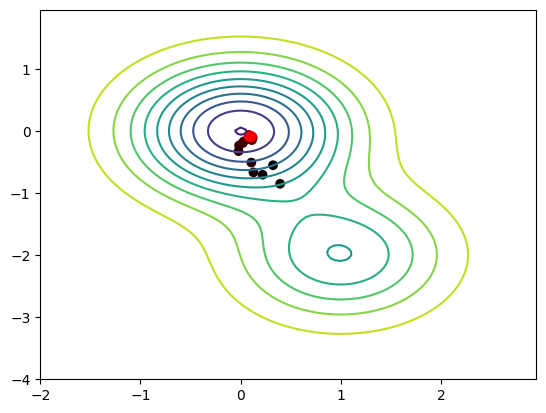

Długość chromosomu = 16, populacja = 10, rozmiar turnieju = 2, szansa na mutację = 0.05, szansa na krzyżowanie = 0.8
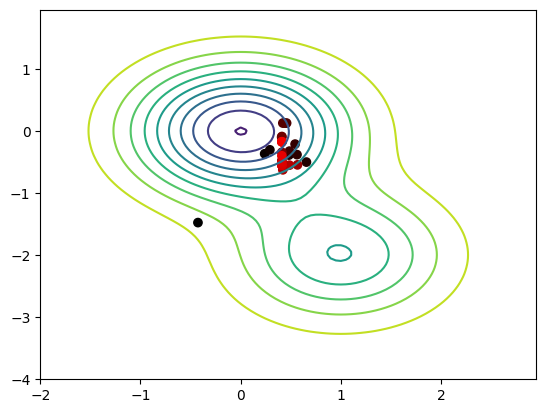

Długość chromosomu = 16, populacja = 500, rozmiar turnieju = 2, szansa na mutację = 0.05, szansa na krzyżowanie = 0.8
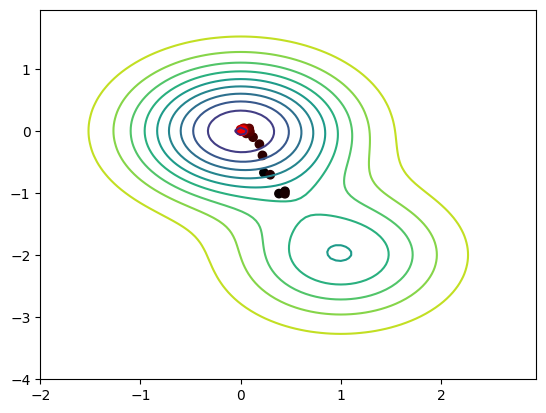

Długość chromosomu = 16, populacja = 500, rozmiar turnieju = 5, szansa na mutację = 0.05, szansa na krzyżowanie = 0.8
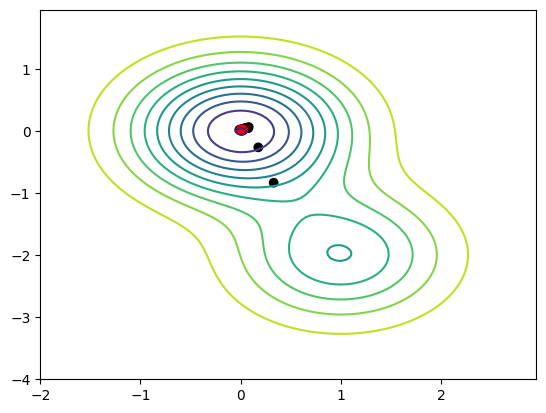

Długość chromosomu = 16, populacja = 500, rozmiar turnieju = 2, szansa na mutację = 0.05, szansa na krzyżowanie = 0.05
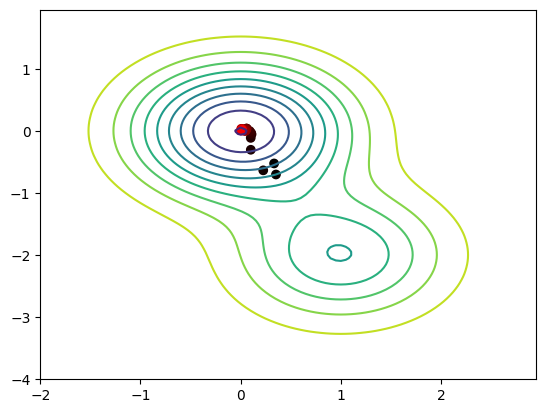

Długość chromosomu = 16, populacja = 500, rozmiar turnieju = 2, szansa na mutację = 0.8, szansa na krzyżowanie = 0.8
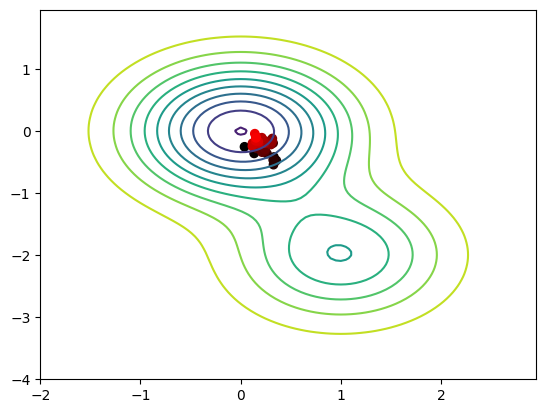